<a href="https://colab.research.google.com/github/p-perrone/UiO_AdvancedRemoteSensing/blob/main/Project1_sketch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import packages
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
import random

In [3]:
# Run authentication
ee.Authenticate()
ee.Initialize(project='dulcet-iterator-470310-n0') # PUT YOUR API KEY (Project ID) HERE!

# Part 1: loading data

In [4]:
# this is for getting rid of edges (usually artifacted)
def mask_edge(image):
  edge = image.lt(-50.0)
  masked_image = image.mask().And(edge.Not())
  return image.updateMask(masked_image)

# testing geometry
svalbard_geom = ee.Geometry.Polygon(
    [[[2501471, 14525773],
      [2572610, 14525773],
      [2572610, 14566293],
      [2501471, 14566293],
      [2501471, 14525773]]],
    proj='EPSG:3857',
    geodesic=False
)


# Part 2: Defining Olga Strait geometry and filtering data

In [5]:
# Define Olga Strait geometry (replace with actual coordinates)
olgastretet_geom = ee.Geometry.Polygon(
    [[[0, 80], [30, 80], [30, 78], [0, 78], [0, 80]]]
)

Sentinel-1 does not operate in a single, fixed mode all the time. It switches between modes (like IW, EW, SM, WV) based on a pre-defined mission plan. These modes have different default polarization configurations.
* Interferometric Wide Swath (IW): The most common mode over land. It is typically programmed to acquire in VV+VH (most common) or HH+HV.
* Extra Wide Swath (EW): Used over large areas like oceans and sea ice. It is often programmed for HH+HV or sometimes VV+VH.
* Wave Mode (WV): Used for sampling ocean waves. It is almost always VV only.
* Stripmap Mode (SM): Offers higher resolution and can be programmed for single (HH or VV) or dual (HH+HV or VV+VH) polarization.

For this work, based on existing literature, we focus on HH, HV, HH+HV with EW.

In [6]:
polarizations = ['HH', 'HV']
svalbard_s1_dict = {}

In [7]:

# Sentinel-1 collection for Svalb

for pol in polarizations:
    svalbard_s1_dict[pol] = (

    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filterBounds(svalbard_geom)
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', pol))
    .filter(ee.Filter.eq('instrumentMode', 'EW'))
    .select(pol)
    .map(mask_edge)
    )

    # https://www.sciencedirect.com/science/article/pii/S0034425724002116?via%3Dihub


In [8]:
svalbard_s1_pol = [
svalbard_s1HH := svalbard_s1_dict['HH'],
svalbard_s1HV := svalbard_s1_dict['HV']]

In [9]:
# time ranges
spring = ee.Filter.date('2025-03-01', '2025-04-20')
late_spring = ee.Filter.date('2025-04-21', '2025-06-10')
summer = ee.Filter.date('2025-06-11', '2025-08-31')

seasons = [spring, late_spring, summer]

In [10]:
Map = geemap.Map()
Map.centerObject(olgastretet_geom, zoom=6)
Map.addLayer(svalbard_s1HH, {'min': -25, 'max': 5}, 'Sentinel-1') # display a certain range of dB
Map

Map(center=[79.33695198759294, 14.999999999999998], controls=(WidgetControl(options=['position', 'transparent_…

In [11]:
# building the Sentinel-1 polarizations-seasons dataframe
season_names = ['spring', 'late_spring', 'summer']

svalbard_s1 = pd.DataFrame(
    index=polarizations,
    columns=season_names,
)

for pol in polarizations:
    for i, season_filter in enumerate(seasons):

        filtered_collection = svalbard_s1_dict[pol].filter(season_filter)

        svalbard_s1.loc[pol, season_names[i]] = filtered_collection

display(svalbard_s1)

,spring,late_spring,summer
HH,"ee.ImageCollection({\n ""functionInvocationVal...","ee.ImageCollection({\n ""functionInvocationVal...","ee.ImageCollection({\n ""functionInvocationVal..."
HV,"ee.ImageCollection({\n ""functionInvocationVal...","ee.ImageCollection({\n ""functionInvocationVal...","ee.ImageCollection({\n ""functionInvocationVal..."


In [46]:
svalbard_s1_spring = [
svalbard_s1HH_spring := svalbard_s1.loc['HH', 'spring'],
svalbard_s1HV_spring := svalbard_s1.loc['HV', 'spring']]

svalbard_s1_latespring = [
svalbard_s1HH_latespring := svalbard_s1.loc['HH', 'late_spring'],
svalbard_s1HV_latespring := svalbard_s1.loc['HV', 'late_spring']]

svalbard_s1_summer = [
svalbard_s1HH_summer := svalbard_s1.loc['HH', 'summer'],
svalbard_s1HV_summer := svalbard_s1.loc['HV', 'summer']]

In [72]:
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

In [57]:
"GEMINI HELPED"

def dates_with_data(collection, geometry):
    """ Finds the dates in which layers of a collection exist in a given geometry.

        Parameters:
        :: collection = layers collection
        :: geometry   = area of interest

        Returns:
        :: dates = list of dates with data (as 'yyyy-MM-ddTHH:mm:ss' strings)
    """

    # filter the collection by geometry
    filtered_collection = collection.filterBounds(geometry)

    # get a list of all image dates in the filtered collection
    # system:time_start is an attribute of every image (= starting time of aquisition)
    image_dates = ee.List(filtered_collection.aggregate_array('system:time_start'))

    # Check if there are any images
    if image_dates.size().getInfo() > 0:
        # Convert timestamps to dates and format them as strings
        dates = image_dates.map(lambda time: ee.Date(time).format(None, 'GMT'))
        return dates.sort().getInfo()
    else:
        return None

# Find the dates with data for HH polarization in the spring collection
# Define the sea ice geometry using the provided diagonal vertices
# Coordinates are in EPSG:3857
sea_ice_geom = ee.Geometry.Polygon(
    [[[2501471, 14525773],
      [2572610, 14525773],
      [2572610, 14566293],
      [2501471, 14566293],
      [2501471, 14525773]]],
    proj='EPSG:3857',  # Specify the CRS here
    geodesic=False # Set to False for projected coordinates
)

dates_spring_HH = dates_with_data(svalbard_s1HH_spring, sea_ice_geom)
dates_spring_HV = dates_with_data(svalbard_s1HV_spring, sea_ice_geom)

dates_latespring = dates_with_data(svalbard_s1HH_latespring, sea_ice_geom)
dates_summer = dates_with_data(svalbard_s1HH_summer, sea_ice_geom)

# they are apparently the same
print(dates_spring_HH == dates_spring_HV)

dates_spring = dates_spring_HH
# Print the dates found
print(dates_spring)
print(dates_latespring)

True
['2025-03-01T05:50:27', '2025-03-02T06:31:37', '2025-03-03T05:34:02', '2025-03-05T05:17:33', '2025-03-06T05:58:42', '2025-03-08T05:42:13', '2025-03-09T06:23:23', '2025-03-10T05:25:47', '2025-03-11T06:06:57', '2025-03-13T05:50:28', '2025-03-14T06:31:37', '2025-03-15T05:34:02', '2025-03-17T05:17:33', '2025-03-18T05:58:42', '2025-03-20T05:42:13', '2025-03-21T06:23:23', '2025-03-22T05:25:48', '2025-03-23T06:06:57', '2025-03-25T05:50:28', '2025-03-26T06:31:37', '2025-03-27T05:34:02', '2025-03-28T05:24:44', '2025-03-29T05:17:33', '2025-03-29T06:05:44', '2025-03-30T05:58:43', '2025-04-01T05:42:14', '2025-04-02T06:23:23', '2025-04-03T05:25:48', '2025-04-04T06:06:57', '2025-04-06T05:50:28', '2025-04-07T06:31:38', '2025-04-08T05:34:02', '2025-04-10T05:17:33', '2025-04-10T06:05:45', '2025-04-11T05:58:42', '2025-04-12T05:49:22', '2025-04-13T05:42:13', '2025-04-14T06:23:23', '2025-04-15T05:25:47', '2025-04-16T06:06:57', '2025-04-17T05:57:34', '2025-04-18T05:50:28', '2025-04-19T06:31:38']
['202

By using only HH and HV we make sure to have images of the same location always at the same time. Probably the acquisition method of S1 has always been EW in the last thre years (?)

### Visualizing S1 data for different seasons

In [44]:
rnd_state = 122
random.seed(rnd_state) #35
# Spring
SpringMap = geemap.Map()
SpringMap.centerObject(svalbard_geom, zoom=6)
spring_list = svalbard_s1HH_spring.toList(svalbard_s1HH_spring.size())
spring_s1_mosaics = []
spring_s1_day_mosaics = []

cmaps = ['bone', 'viridis']

if dates_spring:
        rnd_date_str = random.choice(dates_spring)
        rnd_date = ee.Date(rnd_date_str)

else:
        print("No HH data dates found in spring to select a random date from.")

# adding some layers
for cmap, ic, pol in zip(cmaps, svalbard_s1_spring, polarizations):
    # adding season mosaics (whole spring)
    ic_mosaic = ic.mosaic()
    spring_s1_mosaics.append(ic_mosaic)
    #SpringMap.addLayer(ic_mosaic, {'min': -25, 'max': 5}, f'{pol} Mosaic')

    # adding random daily mosaics
    # check if the date list is not empty

    ic_date = ic.filterDate(rnd_date, rnd_date.advance(1, 'day')) # Filter for the whole day

    # Mosaic the images for the selected date
    ic_day_mosaic = ic_date.mosaic()
    spring_s1_day_mosaics.append(ic_day_mosaic)

    # Add the mosaicked image from the random date to the map
    SpringMap.addLayer(ic_day_mosaic, {'min': -35, 'max': 10, 'palette': 'bone'}, f'{pol} on {rnd_date.format("YYYY-MM-dd").getInfo()}')

SpringMap

Map(center=[78.32673233318731, 22.790622575802143], controls=(WidgetControl(options=['position', 'transparent_…

In [56]:
rnd_state = 56
random.seed(rnd_state) #35
# Late Spring
LateSpringMap = geemap.Map() # Changed map variable name
LateSpringMap.centerObject(svalbard_geom, zoom=6)
# spring_list = svalbard_s1HH_spring.toList(svalbard_s1HH_spring.size()) # This line is not used for mapping
late_spring_s1_mosaics = [] # Changed variable name
late_spring_s1_day_mosaics = [] # Changed variable name

cmaps = ['bone', 'viridis']

# pick random date from late spring dates
# Make sure dates_latespring has been populated by running the previous cell
if dates_latespring: # Changed from dates_spring
        rnd_date_str = random.choice(dates_latespring) # Changed from dates_spring
        rnd_date = ee.Date(rnd_date_str)

else:
        print("No HH data dates found in late spring to select a random date from.") # Updated message

# adding some layers for late spring
for cmap, ic, pol in zip(cmaps, svalbard_s1_latespring, polarizations): # Changed from svalbard_s1_spring
    # adding season mosaics (whole late spring)
    ic_mosaic = ic.mosaic()
    late_spring_s1_mosaics.append(ic_mosaic) # Changed variable name
    #LateSpringMap.addLayer(ic_mosaic, {'min': -25, 'max': 5}, f'{pol} Late Spring Mosaic') # Example of adding mosaic

    # adding random daily mosaics
    # check if the date list is not empty

    ic_date = ic.filterDate(rnd_date, rnd_date.advance(1, 'day')) # Filter for the whole day

    # Mosaic the images for the selected date
    ic_day_mosaic = ic_date.mosaic()
    late_spring_s1_day_mosaics.append(ic_day_mosaic) # Changed variable name

    # Add the mosaicked image from the random date to the map
    LateSpringMap.addLayer(ic_day_mosaic, {'min': -70, 'max': 10, 'palette': 'bone', 'cmap': cmap}, f'{pol} on {rnd_date.format("YYYY-MM-dd").getInfo()} (Late Spring)') # Updated layer name

LateSpringMap # Display the new map variable

Map(center=[78.32673233318731, 22.790622575802143], controls=(WidgetControl(options=['position', 'transparent_…

In [95]:
rnd_state = 23
random.seed(rnd_state) #35
# Summer
SummerMap = geemap.Map()
SummerMap.centerObject(svalbard_geom, zoom=6)
summer_s1_mosaics = [] # Changed variable name from late_spring_s1_mosaics
summer_s1_day_mosaics = [] # Changed variable name from late_spring_s1_day_mosaics

cmaps = ['bone', 'viridis']

# pick random date from summer dates
# Make sure dates_summer has been populated by running the previous cell
if dates_summer: # Changed from dates_latespring
        rnd_date_str = random.choice(dates_summer) # Changed from dates_latespring
        rnd_date = ee.Date(rnd_date_str)

else:
        print("No HH data dates found in summer to select a random date from.") # Updated message

date = ee.Date('2025-08-09')
# adding some layers for summer
for cmap, ic, pol in zip(cmaps, svalbard_s1_summer, polarizations): # Changed from svalbard_s1_latespring
    # adding season mosaics (whole summer)
    ic_mosaic = ic.mosaic()
    summer_s1_mosaics.append(ic_mosaic) # Changed variable name
    #SummerMap.addLayer(ic_mosaic, {'min': -25, 'max': 5}, f'{pol} Summer Mosaic') # Example of adding mosaic

    # adding random daily mosaics
    # check if the date list is not empty


    ic_date = ic.filterDate(date, date.advance(1, 'day')) # Filter for the whole day

    # Mosaic the images for the selected date
    ic_day_mosaic = ic_date.mosaic()
    summer_s1_day_mosaics.append(ic_day_mosaic) # Changed variable name

    # Add the mosaicked image from the random date to the map
    SummerMap.addLayer(ic_day_mosaic, {'min': -60, 'max': 10, 'palette': 'bone', 'cmap': cmap}, f'{pol} on {date.format("YYYY-MM-dd").getInfo()} (Summer)') # Updated layer name

SummerMap # Display the new map variable

Map(center=[78.32673233318731, 22.790622575802143], controls=(WidgetControl(options=['position', 'transparent_…

In [97]:
# Access the Sentinel-2 Level-2A image collection (Surface Reflectance)
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

# Filter Sentinel-2 collection by geometry and date range (summer)
# Use the start and end date strings directly
s2_summer = s2_collection.filterBounds(svalbard_geom).filterDate(date.advance(1, 'day'))

# Filter for images with less than a certain percentage of cloud cover (e.g., 10%)
s2_summer_filtered = s2_summer.filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 80)

# Select the true color bands (Red, Green, Blue)
rgb_bands = ['B4', 'B3', 'B2']
s2_summer_rgb = s2_summer_filtered.select(rgb_bands)

# Create a median composite image from the filtered collection
s2_summer_composite = s2_summer_rgb.mosaic()

# Define visualization parameters for true color
s2_vis_params = {
    'min': 0,
    'max': 3000, # Adjust max based on typical surface reflectance values
    'bands': rgb_bands
}

# Add the Sentinel-2 true color composite to the SummerMap
SummerMap.addLayer(s2_summer_composite, s2_vis_params, 'Sentinel-2 True Color (Summer)')

# Display the map with the new layer
SummerMap

Map(bottom=1315.0, center=[79.24538842837468, 32.34375000000001], controls=(WidgetControl(options=['position',…

In [16]:
# since I have already defined the polygon this cell is unuseful, but I will keep it just in case I'll need a new polygon
drawn_features = SpringMap.draw_last_feature
drawn_rectangle = drawn_features

if drawn_rectangle:
    # Get the geometry of the feature
    rectangle_geometry = drawn_rectangle.geometry()

    # Get the coordinates of the geometry as a Python object
    coordinates = rectangle_geometry.getInfo()['coordinates']

    # Print the coordinates
    print("Coordinates of the drawn rectangle:")
    print(coordinates)
else:
    print("Cannot extract coordinates as no rectangle feature is available.")

Cannot extract coordinates as no rectangle feature is available.


In [17]:
# this is a good area to see a bit how the radar performs with sea ice. In the selected date
# (seed = 35, 2025-04-12), there is some bare ice, different ice textures, snow on ice and deep sea water
test_geom = ee.Geometry.Polygon([[36.683029, 80.070371], [36.683029, 80.390982], [40.747361, 80.390982], [40.747361, 80.070371], [36.683029, 80.070371]])

In [18]:
# Define the number of random points to generate initially (significantly more than needed)
initial_num_points = 10000

# Generate random points within the bounds of the sea ice geometry
random_points = ee.FeatureCollection.randomPoints(test_geom, initial_num_points,seed=42)
SpringMap.addLayer(random_points, {'color': '00FF00'}, 'Sampled Points', opacity=0.2)
SpringMap.addLayer(test_geom,
    vis_params={"color": "red"},
    name="Sampling Area",
    opacity=0.2)
SpringMap

Map(center=[78.32673233318731, 22.790622575802143], controls=(WidgetControl(options=['position', 'transparent_…

In [19]:
# Define the number of random points to generate initially (significantly more than needed)
initial_num_points = 10000

# Generate random points within the bounds of the sea ice geometry
random_points = ee.FeatureCollection.randomPoints(test_geom, initial_num_points,seed=42)
SpringMap.addLayer(random_points, {'color': '00FF00'}, 'Sampled Points', opacity=0.2)
SpringMap.addLayer(test_geom,
    vis_params={"color": "red"},
    name="Sampling Area",
    opacity=0.2)
SpringMap

Map(center=[78.32673233318731, 22.790622575802143], controls=(WidgetControl(options=['position', 'transparent_…

In [20]:
random_points_df = geemap.ee_to_df(random_points)

def get_coordinates_from_fc(feature_collection):
    """Extract coordinates from a FeatureCollection"""
    coordinates = feature_collection.geometry().coordinates().getInfo()
    return coordinates

# Get all coordinates
coords = get_coordinates_from_fc(random_points)

# Convert to list of [lon, lat] pairs
lon_lat_pairs = [[coord[0], coord[1]] for coord in coords]
coords_df = pd.DataFrame(coords)
coords_df.head()

,0,1
0,39.591411,80.083491
1,38.234796,80.270830
2,39.540462,80.179228
3,39.008549,80.105339
4,38.423983,80.179396


In [21]:
#SAMPLING

sampled_s1_spring = []
for image in spring_s1_day_mosaics:
    sampled = image.sampleRegions(
      collection=random_points,
      scale=10,
      geometries=True
      )
    sampled_s1_spring.append(sampled)

print(sampled_s1_spring)

[<ee.featurecollection.FeatureCollection object at 0x7a3eeef5b3b0>, <ee.featurecollection.FeatureCollection object at 0x7a3eeed814c0>]


In [22]:
sampleHH_df = geemap.ee_to_df(sampled_s1_spring[0])
sampleHV_df = geemap.ee_to_df(sampled_s1_spring[1])
sampled_s1_df = pd.concat([sampleHH_df, sampleHV_df], axis=1)

Text(0, 0.5, 'HV')

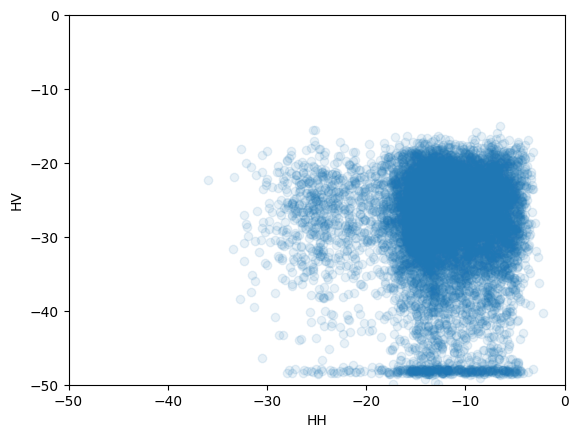

In [23]:
plt.scatter(sampled_s1_df['HH'], sampled_s1_df['HV'], alpha=0.1)
plt.xlim(-50, 0)
plt.ylim(-50, 0)
plt.xlabel('HH')
plt.ylabel('HV')

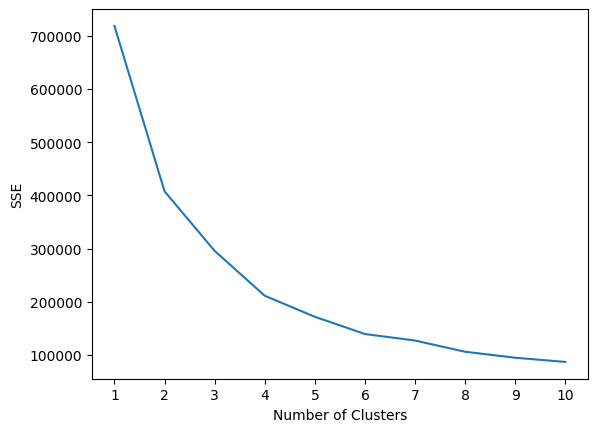

In [28]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

#sampled_s1_df_s = StandardScaler().fit_transform(sampled_s1_df.dropna())

common_params = {
    "n_init": "auto",
    "random_state": 67,
    "max_iter" : 1000
}

sse_kmeans = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k,
                    **common_params)
    kmeans.fit(sampled_s1_df.dropna())
    sse_kmeans.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse_kmeans, label="K-Means")
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [31]:
kmeans3 = KMeans(n_clusters=3,
                    **common_params)
kmeans3.fit(sampled_s1_df.dropna())
len(kmeans3.labels_)
clusters = pd.Series(kmeans3.labels_)

dbs = DBSCAN(eps=0.5, min_samples=5)
dbs.fit(sampled_s1_df.dropna())
dbscans = pd.Series(dbs.labels_)

gmm = GaussianMixture(n_components=5)
gmm.fit(sampled_s1_df.dropna())
gmm_labels = pd.Series(gmm.labels_)

AttributeError: 'GaussianMixture' object has no attribute 'labels_'

In [ ]:
# Rename columns in coords_df for clarity
coords_df_renamed = coords_df.rename(columns={0: "longitude", 1: "latitude"})
clusters.name = "cluster"
dbscans.name = "dbscans"
sampled_data_with_clusters = pd.concat([sampled_s1_df, clusters, dbscans], axis=1)

# Merge the coordinates DataFrame with the sampled data and clusters DataFrame
# Merge based on the index
sampled_s1_dfclass = pd.merge(
    coords_df_renamed,
    sampled_data_with_clusters,
    left_index=True,
    right_index=True,
    how='left' # Use a left merge to keep all original points from coords_df
).dropna()

# Display the resulting DataFrame
sampled_s1_dfclass

In [ ]:
# Drop rows with NaN values in 'HH', 'HV', or 'cluster' before plotting
# This ensures only points with valid data and cluster assignments are plotted
plot_df = sampled_s1_dfclass.dropna(subset=['HH', 'HV', 'cluster']).copy()

# Create the scatter plot
plt.figure(figsize=(10, 8))

# Use the 'cluster' column for coloring with a colormap
scatter = plt.scatter(
    plot_df['HH'],
    plot_df['HV'],
    c=plot_df['cluster'],
    cmap='viridis',  # Use a colormap (you can choose a different one)
    s=10,           # Marker size
    alpha=0.5,      # Transparency
)

plt.xlim(-50, 0)
plt.ylim(-50, 0)
plt.xlabel('HH Backscatter (dB)')
plt.ylabel('HV Backscatter (dB)')
plt.title('Scatter Plot of HH vs HV Colored by K-means Cluster')
plt.grid(True)

# Add a colorbar to show the mapping from color to cluster label
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Label')

# Set the ticks of the colorbar to correspond to the cluster labels
# Assuming cluster labels are integers from 0 to n_clusters - 1
num_clusters = int(plot_df['cluster'].max()) + 1 # Get the maximum cluster label and add 1 for the count
cbar.set_ticks(np.arange(num_clusters))
cbar.set_ticklabels([f'Cluster {i}' for i in range(num_clusters)])


plt.show()

In [ ]:
# Drop rows with NaN values in 'HH', 'HV', or 'cluster' before plotting
# This ensures only points with valid data and cluster assignments are plotted
plot_df = sampled_s1_dfclass.dropna(subset=['HH', 'HV', 'dbscans']).copy()

# Create the scatter plot
scatter = plt.scatter(
    plot_df['HH'],
    plot_df['HV'],
    c=plot_df['dbscans'],
    cmap='viridis',  # Use a colormap (you can choose a different one)
    s=10,           # Marker size
    alpha=0.5,      # Transparency
)

plt.xlim(-50, 0)
plt.ylim(-50, 0)
plt.xlabel('HH (dB)')
plt.ylabel('HV (dB)')
plt.title('DBSCAN')
plt.grid(True)

# Add a colorbar to show the mapping from color to cluster label
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Label')

In [ ]:

"""GEMINI HELPED - plotting on map points from dataframe"""
sampled_fc = geemap.df_to_ee(
    sampled_s1_dfclass, # Use the cleaned and selected DataFrame
    csv_columns=['HH', 'HV', 'clusters'], # Include the new 'cluster' column
    # Remove x and y arguments as columns are now named 'longitude' and 'latitude'
    geometries=True
)

cluster_colors = ['FF0000', '00FF00', '0000FF']  # Red, Green, Blue

# Define a color palette for the clusters
# You can customize these colors
clusters_image = sampled_fc.reduceToImage(
    properties=['clusters'],
    reducer=ee.Reducer.first()
).visualize(
    palette=cluster_colors
)

# Add to map
SpringMap.addLayer(
    clusters_image,
    {},
    'K-means Clusters'
)

# Center the map on the points
SpringMap.centerObject(sampled_fc, zoom=9)

SpringMap

In [ ]:
svalbard_lsib = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017") \
    .filter(ee.Filter.eq('country_na', 'Svalbard'))

print("Svalbard from LSIB:", svalbard_lsib.size().getInfo())


# Add to map
SpringMap = geemap.Map()
SpringMap.addLayer(svalbard_lsib, {'color': 'blue'}, 'Svalbard GAUL')
SpringMap.centerObject(svalbard_lsib, 6)
SpringMap